<a href="https://colab.research.google.com/github/bilalzardoa/machine-learning/blob/main/cifar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [88]:
import keras
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt

In [89]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

val_split = int(0.9 * x_train.shape[0])

x_train, x_val = x_train[:val_split], x_train[val_split:]
y_train, y_val = y_train[:val_split], y_train[val_split:]

In [90]:
x_train.shape , y_train.shape , x_test.shape , y_test.shape

((45000, 32, 32, 3), (45000, 1), (10000, 32, 32, 3), (10000, 1))

In [91]:
normalization_layer = keras.layers.Normalization()
normalization_layer.adapt(x_train)

x_train_normalized = normalization_layer(x_train).numpy()
x_val_normalized = normalization_layer(x_val).numpy()
x_test_normalized  = normalization_layer(x_test).numpy()

In [92]:
# big convolutions on small feature maps are bad
def get_model():
    model = keras.Sequential()
    model.add(keras.Input(shape=(32, 32, 3)))

    # First block
    model.add(keras.layers.Conv2D(32, 3, padding='same', activation='relu'))
    model.add(keras.layers.Conv2D(32, 3, padding='same', activation='relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
    model.add(keras.layers.Dropout(0.3))

    # Second block
    model.add(keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
    model.add(keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
    model.add(keras.layers.Dropout(0.3))

    # Third block
    model.add(keras.layers.Conv2D(128, 3, padding='same', activation='relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
    model.add(keras.layers.Dropout(0.3))

    # Classification head
    model.add(keras.layers.GlobalAveragePooling2D())  # (128,) → averages each 4x4 map to 1 value
    model.add(keras.layers.Dense(128, activation='relu'))  # (128,)
    model.add(keras.layers.Dense(10, activation='softmax'))  # (10,) class probabilities

    return model


In [93]:
model = get_model()

In [94]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_35 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 157,226 (614.16 KB)

 Trainable params: 157,226 (614.16 KB)

 Non-trainable params: 0 (0.00 B)

In [95]:
lr = 0.001
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=lr),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])


early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
)

In [96]:
history = model.fit(x_train_normalized, y_train, batch_size=32, epochs=50,validation_data=(x_val_normalized,y_val),callbacks=[early_stopping], verbose=2)

Epoch 1/50
1407/1407 - 16s - 11ms/step - accuracy: 0.3783 - loss: 1.6382 - val_accuracy: 0.5172 - val_loss: 1.3064
Epoch 2/50
1407/1407 - 7s - 5ms/step - accuracy: 0.5580 - loss: 1.2159 - val_accuracy: 0.6196 - val_loss: 1.0484
Epoch 3/50
1407/1407 - 6s - 4ms/step - accuracy: 0.6291 - loss: 1.0342 - val_accuracy: 0.6892 - val_loss: 0.9016
Epoch 4/50
1407/1407 - 10s - 7ms/step - accuracy: 0.6690 - loss: 0.9332 - val_accuracy: 0.7030 - val_loss: 0.8543
Epoch 5/50
1407/1407 - 10s - 7ms/step - accuracy: 0.6948 - loss: 0.8592 - val_accuracy: 0.7274 - val_loss: 0.8046
Epoch 6/50
1407/1407 - 11s - 7ms/step - accuracy: 0.7157 - loss: 0.8070 - val_accuracy: 0.7514 - val_loss: 0.7263
Epoch 7/50
1407/1407 - 7s - 5ms/step - accuracy: 0.7308 - loss: 0.7629 - val_accuracy: 0.7538 - val_loss: 0.7201
Epoch 8/50
1407/1407 - 6s - 4ms/step - accuracy: 0.7384 - loss: 0.7367 - val_accuracy: 0.7740 - val_loss: 0.6564
Epoch 9/50
1407/1407 - 6s - 5ms/step - accuracy: 0.7538 - loss: 0.7046 - val_accuracy: 0.78

In [97]:
model.evaluate(x_test_normalized, y_test,verbose=2)

313/313 - 2s - 6ms/step - accuracy: 0.8050 - loss: 0.5666


[0.5666021108627319, 0.8050000071525574]

In [98]:
def plot_history_smooth(history):
    epochs = range(1, len(history.history['accuracy']) + 1)

    # Plot accuracy
    plt.figure(figsize=(10,4))
    plt.plot(epochs, history.history['accuracy'], 'bo-', label='Train Acc')
    if 'val_accuracy' in history.history:
        plt.plot(epochs, history.history['val_accuracy'], 'ro-', label='Val Acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot loss
    plt.figure(figsize=(10,4))
    plt.plot(epochs, history.history['loss'], 'bo-', label='Train Loss')
    if 'val_loss' in history.history:
        plt.plot(epochs, history.history['val_loss'], 'ro-', label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


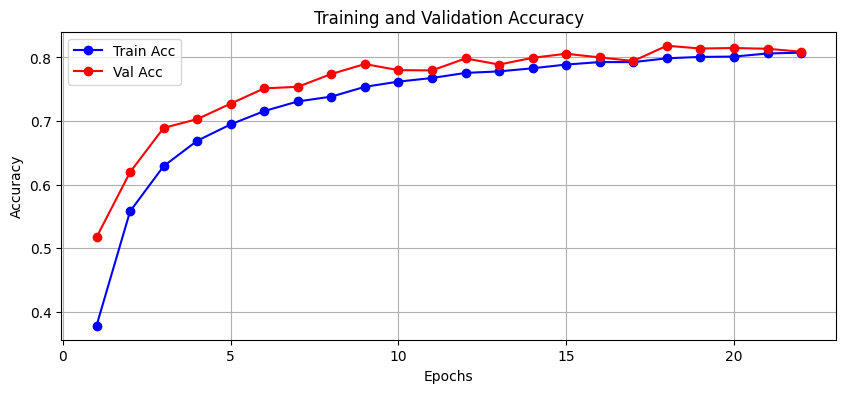

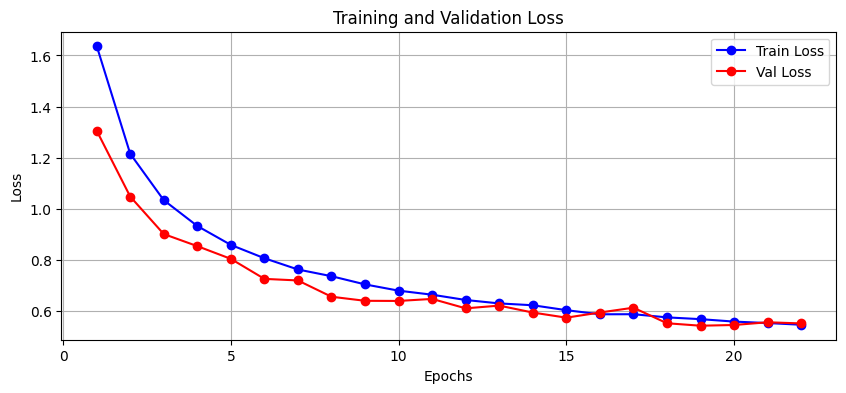

In [99]:
# plot_history(history)
plot_history_smooth(history)